# 🎯 Notebook 05E: Hyperparameter Optimization (FINAL)

**Objective:** Fine-tune CatBoost hyperparameters for maximum performance

**From Phase 4:** CatBoost + SMOTE with 16 features (79.7% recall, 31.8% precision)

**Method:** Optuna Bayesian Optimization (50-100 trials)

**Optimization Goal:** Maximize Recall WITH Precision ≥ 32% constraint

**Expected Outcome:**
- Recall: 79.7% → 81-83%
- Precision: 31.8% → 33-35%
- Production-ready model

**Final Deliverables:**
1. Optimized model (.pkl)
2. SHAP analysis
3. ROC curves & calibration
4. Business impact report
5. Deployment guide

---

## 📦 Step 1: Setup

In [2]:
!pip install shap

  Using cached numpy-2.3.5-cp312-cp312-win_amd64.whl.metadata (60 kB)
   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   ---------------------------------------- 549.3/549.3 kB 3.1 MB/s  0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 2.8 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.8 MB 4.0 MB/s eta 0:00:01
   ---------------------------------- ----- 2.4/2.8 MB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 4.0 MB/s  0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
    --------------------------------------- 0.8/38.1 MB 3.7 MB/s eta 0:00:11
   - -------------------------------------- 1.3/38.1 MB 3.7 MB/s eta 0:00:10
   -- ------------------------------------- 2.4/38.1 MB 3.7 MB/s eta 0:00:10
   --- ------------------------------------ 3.1/38.1 MB 3.8 MB/s eta 0:00:10
   ---- --------------------------

  You can safely remove it manually.
  You can safely remove it manually.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    recall_score, precision_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import shap
import pickle
import time
import json
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 6)

print("✅ Libraries loaded")
print("\n📦 Key libraries:")
print(f"   Optuna: {optuna.__version__}")
print(f"   CatBoost: Available")
print(f"   SHAP: Available")

c:\Users\yaros\Desktop\python\faidm\individual_project\diabetes-classification-ml\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Libraries loaded

📦 Key libraries:
   Optuna: 4.7.0
   CatBoost: Available
   SHAP: Available


## 📊 Step 2: Load Optimal Features from Phase 4

In [2]:
print("=" * 60)
print("LOADING OPTIMAL FEATURES FROM PHASE 4")
print("=" * 60)

# Load optimal features
df = pd.read_csv('C:\\Users\\yaros\\Desktop\\python\\faidm\\individual_project\\diabetes-classification-ml\\Classification_2\\D\\optimal_features_05D.csv')
X = df.drop('Target', axis=1)
y = df['Target']

print(f"\n📊 Dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"   Features: {X.shape[1]}")

# Load Phase 4 results
with open('C:\\Users\\yaros\\Desktop\\python\\faidm\\individual_project\\diabetes-classification-ml\\Classification_2\\D\\feature_selection_results.json', 'r') as f:
    phase4_results = json.load(f)

print(f"\n📋 Phase 4 Baseline:")
print(f"   Features: {phase4_results['n_features_after']}")
print(f"   Recall: {phase4_results['performance_after']['recall']:.3f}")
print(f"   Precision: {phase4_results['performance_after']['precision']:.3f}")
print(f"   → This is the baseline to improve upon")

# Feature list
feature_names = X.columns.tolist()
print(f"\n📋 Optimal Features ({len(feature_names)}):")
for i, feat in enumerate(feature_names, 1):
    print(f"   {i:2d}. {feat}")

# Class distribution
class_counts = y.value_counts().sort_index()
scale_pos_weight = class_counts[0] / class_counts[1]
print(f"\n📊 Target Distribution:")
print(f"   Healthy: {class_counts[0]:,} ({class_counts[0]/len(y)*100:.1f}%)")
print(f"   At-Risk: {class_counts[1]:,} ({class_counts[1]/len(y)*100:.1f}%)")
print(f"   scale_pos_weight: {scale_pos_weight:.2f}")

LOADING OPTIMAL FEATURES FROM PHASE 4

📊 Dataset: 229,781 rows × 17 columns
   Features: 16

📋 Phase 4 Baseline:
   Features: 16
   Recall: 0.797
   Precision: 0.318
   → This is the baseline to improve upon

📋 Optimal Features (16):
    1. HighBP
    2. HighChol
    3. CholCheck
    4. BMI
    5. Smoker
    6. Stroke
    7. HeartDiseaseorAttack
    8. PhysActivity
    9. Fruits
   10. Veggies
   11. HvyAlcoholConsump
   12. MentHlth
   13. Sex
   14. Age
   15. Education
   16. Income

📊 Target Distribution:
   Healthy: 190,055 (82.7%)
   At-Risk: 39,726 (17.3%)
   scale_pos_weight: 4.78


## 🔀 Step 3: Train-Test Split

In [3]:
print("=" * 60)
print("TRAIN-TEST SPLIT")
print("=" * 60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain: {X_train.shape[0]:,} samples")
print(f"Test:  {X_test.shape[0]:,} samples")

TRAIN-TEST SPLIT

Train: 183,824 samples
Test:  45,957 samples


## 📊 Step 4: Baseline Performance (Phase 4 Config)

In [18]:
print("=" * 60)
print("BASELINE: PHASE 4 CONFIGURATION")
print("=" * 60)

print("\n⏳ Training baseline model...")

# Scale
scaler_base = StandardScaler()
X_train_scaled = scaler_base.fit_transform(X_train)
X_test_scaled = scaler_base.transform(X_test)

# SMOTE
smote_base = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote_base.fit_resample(X_train_scaled, y_train)

# Train Phase 4 config
baseline_model = CatBoostClassifier(
    iterations=100,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    verbose=0,
    allow_writing_files=False
)

baseline_model.fit(X_train_smote, y_train_smote)
y_pred_base = baseline_model.predict(X_test_scaled)
y_pred_proba_base = baseline_model.predict_proba(X_test_scaled)[:, 1]

baseline_recall = recall_score(y_test, y_pred_base)
baseline_precision = precision_score(y_test, y_pred_base)
baseline_f1 = f1_score(y_test, y_pred_base)
baseline_roc = roc_auc_score(y_test, y_pred_proba_base)

print(f"\n✅ Baseline Performance:")
print(f"   Recall:    {baseline_recall:.3f}")
print(f"   Precision: {baseline_precision:.3f}")
print(f"   F1-Score:  {baseline_f1:.3f}")
print(f"   ROC-AUC:   {baseline_roc:.3f}")
print(f"\n   → Goal: Beat these numbers with Optuna!")

BASELINE: PHASE 4 CONFIGURATION

⏳ Training baseline model...

✅ Baseline Performance:
   Recall:    0.797
   Precision: 0.318
   F1-Score:  0.454
   ROC-AUC:   0.795

   → Goal: Beat these numbers with Optuna!


## 🔬 Step 5: Define Optuna Objective Function

In [10]:
print("=" * 60)
print("DEFINING OPTUNA OBJECTIVE")
print("=" * 60)

print("\n🎯 Optimization Strategy:")
print("   PRIMARY: Maximize Recall")
print("   CONSTRAINT: Precision ≥ 0.32 (32%)")
print("   METHOD: 3-fold CV to avoid overfitting")

def objective(trial):
    # Suggest hyperparameters
    params = {
        'iterations': trial.suggest_int('iterations', 200, 800),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 50),
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42,
        'verbose': 0,
        'allow_writing_files': False
    }
    
    # Manual 3-fold CV
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    fold_recalls = []
    fold_precisions = []
    
    for train_idx, val_idx in cv.split(X_train_scaled, y_train):
        # Split
        X_fold_train = X_train_scaled[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = X_train_scaled[val_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        # SMOTE on training fold
        smote_fold = SMOTE(random_state=42)
        X_fold_smote, y_fold_smote = smote_fold.fit_resample(X_fold_train, y_fold_train)
        
        # Train
        model = CatBoostClassifier(**params)
        model.fit(X_fold_smote, y_fold_smote)
        
        # Predict on validation
        y_pred = model.predict(X_fold_val)
        fold_recalls.append(recall_score(y_fold_val, y_pred))
        fold_precisions.append(precision_score(y_fold_val, y_pred))
    
    mean_recall = np.mean(fold_recalls)
    mean_precision = np.mean(fold_precisions)
    
    # Penalty if precision < 0.32
    if mean_precision < 0.32:
        return mean_recall - 0.5  # Heavy penalty
    else:
        return mean_recall

print("\n✅ Objective function defined")
print("   Hyperparameters to tune:")
print("     • iterations: 200-800")
print("     • depth: 4-10")
print("     • learning_rate: 0.01-0.3 (log scale)")
print("     • l2_leaf_reg: 1-10")
print("\n   Penalty: -0.5 if precision < 32%")

DEFINING OPTUNA OBJECTIVE

🎯 Optimization Strategy:
   PRIMARY: Maximize Recall
   CONSTRAINT: Precision ≥ 0.32 (32%)
   METHOD: 3-fold CV to avoid overfitting

✅ Objective function defined
   Hyperparameters to tune:
     • iterations: 200-800
     • depth: 4-10
     • learning_rate: 0.01-0.3 (log scale)
     • l2_leaf_reg: 1-10

   Penalty: -0.5 if precision < 32%


SMOTE already adds "synthetic noise" (by interpolating between points). If we add random_strength (which adds noise to the split scoring), we risk creating a "Double Noise" scenario where the model struggles to find any stable signal at all.

we used min_data_in_leaf that Prevents overfitting on small groups
Very relevant for imbalanced data
Works well with SMOTE

5-50 forces model to learn REAL patterns, not synthetic noise

## 🏃 Step 6: Run Optuna Optimization

In [11]:
print("=" * 60)
print("RUNNING OPTUNA OPTIMIZATION")
print("=" * 60)

print("\n⏳ This will take 60 minutes for 100 trials...\n")
print("Each trial tests different hyperparameters via 3-fold CV")
print("Progress will be shown below:\n")

# Create study
study = optuna.create_study(
    direction='maximize',
    study_name='diabetes_catboost_optimization',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Run optimization
start_time = time.time()
study.optimize(objective, n_trials=100, show_progress_bar=True)
elapsed = time.time() - start_time

print(f"\n✅ Optimization Complete! ({elapsed/60:.1f} minutes)")

# Best trial
best_trial = study.best_trial
print(f"\n🏆 BEST TRIAL:")
print(f"   Trial #: {best_trial.number}")
print(f"   Best Recall: {best_trial.value:.3f}")
print(f"\n   Best Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"      {key}: {value}")

[I 2026-02-08 02:38:31,359] A new study created in memory with name: diabetes_catboost_optimization


RUNNING OPTUNA OPTIMIZATION

⏳ This will take 60 minutes for 100 trials...

Each trial tests different hyperparameters via 3-fold CV
Progress will be shown below:



Best trial: 0. Best value: 0.716057:   1%|          | 1/100 [01:10<1:55:31, 70.01s/it]

[I 2026-02-08 02:39:41,369] Trial 0 finished with value: 0.716056765883065 and parameters: {'iterations': 425, 'depth': 10, 'learning_rate': 0.1205712628744377, 'l2_leaf_reg': 6.387926357773329, 'min_data_in_leaf': 12}. Best is trial 0 with value: 0.716056765883065.


Best trial: 0. Best value: 0.716057:   2%|▏         | 2/100 [01:30<1:06:31, 40.73s/it]

[I 2026-02-08 02:40:01,602] Trial 1 finished with value: 0.28612996343452135 and parameters: {'iterations': 293, 'depth': 4, 'learning_rate': 0.19030368381735815, 'l2_leaf_reg': 6.41003510568888, 'min_data_in_leaf': 37}. Best is trial 0 with value: 0.716056765883065.


Best trial: 2. Best value: 0.728989:   3%|▎         | 3/100 [02:09<1:04:50, 40.11s/it]

[I 2026-02-08 02:40:40,980] Trial 2 finished with value: 0.7289890299405473 and parameters: {'iterations': 212, 'depth': 10, 'learning_rate': 0.16967533607196555, 'l2_leaf_reg': 2.9110519961044856, 'min_data_in_leaf': 13}. Best is trial 2 with value: 0.7289890299405473.


Best trial: 2. Best value: 0.728989:   4%|▍         | 4/100 [02:37<56:29, 35.31s/it]  

[I 2026-02-08 02:41:08,918] Trial 3 finished with value: 0.3020199952875652 and parameters: {'iterations': 310, 'depth': 6, 'learning_rate': 0.05958389350068958, 'l2_leaf_reg': 4.887505167779041, 'min_data_in_leaf': 18}. Best is trial 2 with value: 0.7289890299405473.


Best trial: 2. Best value: 0.728989:   5%|▌         | 5/100 [03:21<1:00:33, 38.25s/it]

[I 2026-02-08 02:41:52,388] Trial 4 finished with value: 0.33486979048829435 and parameters: {'iterations': 567, 'depth': 4, 'learning_rate': 0.027010527749605478, 'l2_leaf_reg': 4.297256589643226, 'min_data_in_leaf': 25}. Best is trial 2 with value: 0.7289890299405473.


Best trial: 2. Best value: 0.728989:   6%|▌         | 6/100 [04:21<1:11:30, 45.64s/it]

[I 2026-02-08 02:42:52,380] Trial 5 finished with value: 0.289874328121158 and parameters: {'iterations': 671, 'depth': 5, 'learning_rate': 0.05748924681991978, 'l2_leaf_reg': 6.331731119758382, 'min_data_in_leaf': 7}. Best is trial 2 with value: 0.7289890299405473.


Best trial: 2. Best value: 0.728989:   7%|▋         | 7/100 [05:15<1:15:16, 48.57s/it]

[I 2026-02-08 02:43:46,973] Trial 6 finished with value: 0.38854957706750026 and parameters: {'iterations': 565, 'depth': 5, 'learning_rate': 0.012476394272569451, 'l2_leaf_reg': 9.539969835279999, 'min_data_in_leaf': 49}. Best is trial 2 with value: 0.7289890299405473.


Best trial: 2. Best value: 0.728989:   8%|▊         | 8/100 [06:27<1:25:46, 55.94s/it]

[I 2026-02-08 02:44:58,709] Trial 7 finished with value: 0.3537175931071964 and parameters: {'iterations': 685, 'depth': 6, 'learning_rate': 0.013940346079873234, 'l2_leaf_reg': 7.158097238609412, 'min_data_in_leaf': 25}. Best is trial 2 with value: 0.7289890299405473.


Best trial: 2. Best value: 0.728989:   9%|▉         | 9/100 [07:03<1:15:27, 49.75s/it]

[I 2026-02-08 02:45:34,852] Trial 8 finished with value: 0.4295804183511738 and parameters: {'iterations': 273, 'depth': 7, 'learning_rate': 0.011240768803005551, 'l2_leaf_reg': 9.18388361870904, 'min_data_in_leaf': 16}. Best is trial 2 with value: 0.7289890299405473.


Best trial: 2. Best value: 0.728989:  10%|█         | 10/100 [08:12<1:23:46, 55.85s/it]

[I 2026-02-08 02:46:44,350] Trial 9 finished with value: 0.28742007904873856 and parameters: {'iterations': 598, 'depth': 6, 'learning_rate': 0.05864129169696527, 'l2_leaf_reg': 5.920392514089517, 'min_data_in_leaf': 13}. Best is trial 2 with value: 0.7289890299405473.


Best trial: 2. Best value: 0.728989:  11%|█         | 11/100 [09:46<1:39:49, 67.30s/it]

[I 2026-02-08 02:48:17,618] Trial 10 finished with value: 0.5835874525954786 and parameters: {'iterations': 431, 'depth': 10, 'learning_rate': 0.2704729722717776, 'l2_leaf_reg': 1.2664487532132647, 'min_data_in_leaf': 34}. Best is trial 2 with value: 0.7289890299405473.


Best trial: 2. Best value: 0.728989:  12%|█▏        | 12/100 [10:50<1:37:31, 66.50s/it]

[I 2026-02-08 02:49:22,281] Trial 11 finished with value: 0.7006072765266383 and parameters: {'iterations': 426, 'depth': 10, 'learning_rate': 0.12040035550822742, 'l2_leaf_reg': 2.6184953555663, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.7289890299405473.


Best trial: 12. Best value: 0.76744:  13%|█▎        | 13/100 [11:12<1:16:53, 53.03s/it]

[I 2026-02-08 02:49:44,318] Trial 12 finished with value: 0.7674396162334142 and parameters: {'iterations': 207, 'depth': 9, 'learning_rate': 0.13001429961399444, 'l2_leaf_reg': 3.55170737231674, 'min_data_in_leaf': 12}. Best is trial 12 with value: 0.7674396162334142.


Best trial: 13. Best value: 0.77238:  14%|█▍        | 14/100 [11:34<1:02:27, 43.57s/it]

[I 2026-02-08 02:50:06,035] Trial 13 finished with value: 0.7723796886301143 and parameters: {'iterations': 206, 'depth': 9, 'learning_rate': 0.12217609953199608, 'l2_leaf_reg': 3.402919656508326, 'min_data_in_leaf': 20}. Best is trial 13 with value: 0.7723796886301143.


Best trial: 13. Best value: 0.77238:  15%|█▌        | 15/100 [11:56<52:17, 36.92s/it]  

[I 2026-02-08 02:50:27,526] Trial 14 finished with value: 0.28531187545988723 and parameters: {'iterations': 236, 'depth': 8, 'learning_rate': 0.089631357575207, 'l2_leaf_reg': 3.4703647595423286, 'min_data_in_leaf': 20}. Best is trial 13 with value: 0.7723796886301143.


Best trial: 15. Best value: 0.781033:  16%|█▌        | 16/100 [12:58<1:02:19, 44.52s/it]

[I 2026-02-08 02:51:29,696] Trial 15 finished with value: 0.7810325603724794 and parameters: {'iterations': 780, 'depth': 8, 'learning_rate': 0.03208899494279826, 'l2_leaf_reg': 1.7061614647010264, 'min_data_in_leaf': 33}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  17%|█▋        | 17/100 [14:02<1:09:35, 50.31s/it]

[I 2026-02-08 02:52:33,468] Trial 16 finished with value: 0.2844937696634743 and parameters: {'iterations': 800, 'depth': 8, 'learning_rate': 0.028290169309357398, 'l2_leaf_reg': 1.4624316948918794, 'min_data_in_leaf': 34}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  18%|█▊        | 18/100 [15:03<1:13:10, 53.54s/it]

[I 2026-02-08 02:53:34,549] Trial 17 finished with value: 0.28537479822107514 and parameters: {'iterations': 799, 'depth': 8, 'learning_rate': 0.028069002597357614, 'l2_leaf_reg': 2.249315537973289, 'min_data_in_leaf': 45}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  19%|█▉        | 19/100 [15:38<1:04:49, 48.02s/it]

[I 2026-02-08 02:54:09,684] Trial 18 finished with value: 0.30837597832581765 and parameters: {'iterations': 362, 'depth': 9, 'learning_rate': 0.0382487319418684, 'l2_leaf_reg': 4.464711128101477, 'min_data_in_leaf': 39}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  20%|██        | 20/100 [16:43<1:10:53, 53.17s/it]

[I 2026-02-08 02:55:14,884] Trial 19 finished with value: 0.30957169197647405 and parameters: {'iterations': 715, 'depth': 9, 'learning_rate': 0.0187497569268493, 'l2_leaf_reg': 2.1504189185437608, 'min_data_in_leaf': 30}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  21%|██        | 21/100 [17:17<1:02:23, 47.38s/it]

[I 2026-02-08 02:55:48,769] Trial 20 finished with value: 0.7758722761334008 and parameters: {'iterations': 509, 'depth': 7, 'learning_rate': 0.07942383092448925, 'l2_leaf_reg': 3.6878350104575115, 'min_data_in_leaf': 29}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  22%|██▏       | 22/100 [17:51<56:31, 43.48s/it]  

[I 2026-02-08 02:56:23,152] Trial 21 finished with value: 0.773858519062558 and parameters: {'iterations': 512, 'depth': 7, 'learning_rate': 0.08407654179943173, 'l2_leaf_reg': 3.5424129535232396, 'min_data_in_leaf': 29}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  23%|██▎       | 23/100 [18:26<52:15, 40.72s/it]

[I 2026-02-08 02:56:57,425] Trial 22 finished with value: 0.7698309455149422 and parameters: {'iterations': 515, 'depth': 7, 'learning_rate': 0.08242047873638254, 'l2_leaf_reg': 1.0484163365030768, 'min_data_in_leaf': 27}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  24%|██▍       | 24/100 [18:59<48:47, 38.53s/it]

[I 2026-02-08 02:57:30,836] Trial 23 finished with value: 0.2969225922255233 and parameters: {'iterations': 494, 'depth': 7, 'learning_rate': 0.040221518465885994, 'l2_leaf_reg': 4.924898502150522, 'min_data_in_leaf': 30}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  25%|██▌       | 25/100 [19:40<48:58, 39.18s/it]

[I 2026-02-08 02:58:11,524] Trial 24 finished with value: 0.7718761491148965 and parameters: {'iterations': 619, 'depth': 7, 'learning_rate': 0.07325804587985582, 'l2_leaf_reg': 3.9920417734016596, 'min_data_in_leaf': 43}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  26%|██▌       | 26/100 [20:20<48:37, 39.42s/it]

[I 2026-02-08 02:58:51,525] Trial 25 finished with value: 0.28801788389387795 and parameters: {'iterations': 495, 'depth': 8, 'learning_rate': 0.041127494925465545, 'l2_leaf_reg': 1.8534720394284152, 'min_data_in_leaf': 33}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  27%|██▋       | 27/100 [21:08<51:08, 42.03s/it]

[I 2026-02-08 02:59:39,638] Trial 26 finished with value: 0.30994928794953136 and parameters: {'iterations': 741, 'depth': 7, 'learning_rate': 0.02061842185678261, 'l2_leaf_reg': 2.8448887653360497, 'min_data_in_leaf': 23}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  28%|██▊       | 28/100 [21:31<43:38, 36.37s/it]

[I 2026-02-08 03:00:02,807] Trial 27 finished with value: 0.28663343463291946 and parameters: {'iterations': 367, 'depth': 6, 'learning_rate': 0.09411598376899734, 'l2_leaf_reg': 5.391165462043368, 'min_data_in_leaf': 39}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  29%|██▉       | 29/100 [22:18<46:53, 39.63s/it]

[I 2026-02-08 03:00:50,029] Trial 28 finished with value: 0.7808437653562473 and parameters: {'iterations': 628, 'depth': 8, 'learning_rate': 0.046955112286957625, 'l2_leaf_reg': 7.547835364105744, 'min_data_in_leaf': 31}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  30%|███       | 30/100 [23:06<49:00, 42.01s/it]

[I 2026-02-08 03:01:37,595] Trial 29 finished with value: 0.7792390270252012 and parameters: {'iterations': 646, 'depth': 8, 'learning_rate': 0.04772898381595885, 'l2_leaf_reg': 8.259244418338625, 'min_data_in_leaf': 33}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  31%|███       | 31/100 [23:54<50:35, 43.99s/it]

[I 2026-02-08 03:02:26,206] Trial 30 finished with value: 0.2820394463336422 and parameters: {'iterations': 639, 'depth': 8, 'learning_rate': 0.04376680202251008, 'l2_leaf_reg': 8.260012576390567, 'min_data_in_leaf': 37}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  32%|███▏      | 32/100 [24:49<53:32, 47.24s/it]

[I 2026-02-08 03:03:21,033] Trial 31 finished with value: 0.7736382092003948 and parameters: {'iterations': 762, 'depth': 8, 'learning_rate': 0.04942805001894647, 'l2_leaf_reg': 7.839976741123667, 'min_data_in_leaf': 32}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  33%|███▎      | 33/100 [25:51<57:36, 51.58s/it]

[I 2026-02-08 03:04:22,751] Trial 32 finished with value: 0.28229119381402723 and parameters: {'iterations': 691, 'depth': 9, 'learning_rate': 0.03389401116706152, 'l2_leaf_reg': 8.65911895335051, 'min_data_in_leaf': 37}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  34%|███▍      | 34/100 [26:39<55:26, 50.41s/it]

[I 2026-02-08 03:05:10,405] Trial 33 finished with value: 0.766086554095637 and parameters: {'iterations': 644, 'depth': 8, 'learning_rate': 0.06820467104181717, 'l2_leaf_reg': 7.019459719624431, 'min_data_in_leaf': 27}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  35%|███▌      | 35/100 [27:29<54:35, 50.39s/it]

[I 2026-02-08 03:06:00,757] Trial 34 finished with value: 0.3263112494223739 and parameters: {'iterations': 561, 'depth': 9, 'learning_rate': 0.020715270638814332, 'l2_leaf_reg': 7.430212405100652, 'min_data_in_leaf': 42}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  36%|███▌      | 36/100 [28:00<47:32, 44.57s/it]

[I 2026-02-08 03:06:31,763] Trial 35 finished with value: 0.29387051454559254 and parameters: {'iterations': 458, 'depth': 7, 'learning_rate': 0.04798712784149986, 'l2_leaf_reg': 8.458833094836272, 'min_data_in_leaf': 32}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  37%|███▋      | 37/100 [28:53<49:28, 47.12s/it]

[I 2026-02-08 03:07:24,809] Trial 36 finished with value: 0.28915061537741626 and parameters: {'iterations': 734, 'depth': 8, 'learning_rate': 0.032488392418027034, 'l2_leaf_reg': 9.895180155656732, 'min_data_in_leaf': 24}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  38%|███▊      | 38/100 [29:25<44:08, 42.72s/it]

[I 2026-02-08 03:07:57,279] Trial 37 finished with value: 0.289968801371835 and parameters: {'iterations': 598, 'depth': 5, 'learning_rate': 0.06507682126161372, 'l2_leaf_reg': 6.484613189725284, 'min_data_in_leaf': 36}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  39%|███▉      | 39/100 [29:58<40:27, 39.79s/it]

[I 2026-02-08 03:08:30,226] Trial 38 finished with value: 0.763884007949155 and parameters: {'iterations': 554, 'depth': 6, 'learning_rate': 0.16754291853761064, 'l2_leaf_reg': 9.078588583315385, 'min_data_in_leaf': 29}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  40%|████      | 40/100 [30:47<42:30, 42.50s/it]

[I 2026-02-08 03:09:19,051] Trial 39 finished with value: 0.7755890583615322 and parameters: {'iterations': 666, 'depth': 8, 'learning_rate': 0.05201592223794252, 'l2_leaf_reg': 7.787996980980392, 'min_data_in_leaf': 22}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  41%|████      | 41/100 [31:54<48:59, 49.81s/it]

[I 2026-02-08 03:10:25,931] Trial 40 finished with value: 0.29481439160696865 and parameters: {'iterations': 767, 'depth': 9, 'learning_rate': 0.022320302219101678, 'l2_leaf_reg': 6.795408286736052, 'min_data_in_leaf': 40}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  42%|████▏     | 42/100 [32:42<47:43, 49.37s/it]

[I 2026-02-08 03:11:14,256] Trial 41 finished with value: 0.7756205464747948 and parameters: {'iterations': 667, 'depth': 8, 'learning_rate': 0.05271545596212797, 'l2_leaf_reg': 7.7606764360321465, 'min_data_in_leaf': 22}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  43%|████▎     | 43/100 [33:32<46:56, 49.41s/it]

[I 2026-02-08 03:12:03,755] Trial 42 finished with value: 0.2867907415358891 and parameters: {'iterations': 692, 'depth': 8, 'learning_rate': 0.03404179228052652, 'l2_leaf_reg': 5.6300918898755885, 'min_data_in_leaf': 26}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  44%|████▍     | 44/100 [34:11<43:12, 46.29s/it]

[I 2026-02-08 03:12:42,772] Trial 43 finished with value: 0.7635692842422449 and parameters: {'iterations': 602, 'depth': 7, 'learning_rate': 0.10375220728259728, 'l2_leaf_reg': 7.642543396351867, 'min_data_in_leaf': 31}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  45%|████▌     | 45/100 [34:50<40:34, 44.26s/it]

[I 2026-02-08 03:13:22,290] Trial 44 finished with value: 0.7798997813641969 and parameters: {'iterations': 537, 'depth': 8, 'learning_rate': 0.05715125350234474, 'l2_leaf_reg': 8.15428651995279, 'min_data_in_leaf': 35}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  46%|████▌     | 46/100 [35:25<37:12, 41.35s/it]

[I 2026-02-08 03:13:56,853] Trial 45 finished with value: 0.2848398864341587 and parameters: {'iterations': 528, 'depth': 7, 'learning_rate': 0.061611734786641156, 'l2_leaf_reg': 8.936772954000748, 'min_data_in_leaf': 34}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  47%|████▋     | 47/100 [36:44<46:25, 52.55s/it]

[I 2026-02-08 03:15:15,542] Trial 46 finished with value: 0.7384914985628844 and parameters: {'iterations': 543, 'depth': 10, 'learning_rate': 0.07119733098319479, 'l2_leaf_reg': 5.961362018981035, 'min_data_in_leaf': 36}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  48%|████▊     | 48/100 [37:18<40:52, 47.16s/it]

[I 2026-02-08 03:15:50,105] Trial 47 finished with value: 0.34739303877627625 and parameters: {'iterations': 448, 'depth': 6, 'learning_rate': 0.024123588517275103, 'l2_leaf_reg': 9.657060681450936, 'min_data_in_leaf': 48}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  49%|████▉     | 49/100 [38:16<42:54, 50.47s/it]

[I 2026-02-08 03:16:48,321] Trial 48 finished with value: 0.7778231728192825 and parameters: {'iterations': 580, 'depth': 9, 'learning_rate': 0.0445546697789808, 'l2_leaf_reg': 8.102713689030837, 'min_data_in_leaf': 28}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  50%|█████     | 50/100 [39:13<43:31, 52.23s/it]

[I 2026-02-08 03:17:44,662] Trial 49 finished with value: 0.291825186193185 and parameters: {'iterations': 582, 'depth': 9, 'learning_rate': 0.030977970872702484, 'l2_leaf_reg': 8.1597831437045, 'min_data_in_leaf': 35}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  51%|█████     | 51/100 [40:55<54:55, 67.26s/it]

[I 2026-02-08 03:19:26,978] Trial 50 finished with value: 0.32307032623117016 and parameters: {'iterations': 646, 'depth': 10, 'learning_rate': 0.017146263620090915, 'l2_leaf_reg': 7.220139439673853, 'min_data_in_leaf': 32}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  52%|█████▏    | 52/100 [41:45<49:39, 62.07s/it]

[I 2026-02-08 03:20:16,952] Trial 51 finished with value: 0.2863186931042304 and parameters: {'iterations': 473, 'depth': 9, 'learning_rate': 0.044921942208501126, 'l2_leaf_reg': 9.30954925426289, 'min_data_in_leaf': 28}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  53%|█████▎    | 53/100 [42:36<45:53, 58.58s/it]

[I 2026-02-08 03:21:07,391] Trial 52 finished with value: 0.7772881867749533 and parameters: {'iterations': 577, 'depth': 8, 'learning_rate': 0.057457796446379605, 'l2_leaf_reg': 8.629909946458845, 'min_data_in_leaf': 30}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  54%|█████▍    | 54/100 [43:29<43:47, 57.11s/it]

[I 2026-02-08 03:22:01,068] Trial 53 finished with value: 0.7754946623385645 and parameters: {'iterations': 625, 'depth': 8, 'learning_rate': 0.05802984110397456, 'l2_leaf_reg': 8.750217329716605, 'min_data_in_leaf': 25}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  55%|█████▌    | 55/100 [44:30<43:44, 58.32s/it]

[I 2026-02-08 03:23:02,217] Trial 54 finished with value: 0.30346739701267655 and parameters: {'iterations': 596, 'depth': 9, 'learning_rate': 0.02567584196949412, 'l2_leaf_reg': 8.368822481339594, 'min_data_in_leaf': 31}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 15. Best value: 0.781033:  56%|█████▌    | 56/100 [45:21<41:00, 55.92s/it]

[I 2026-02-08 03:23:52,540] Trial 55 finished with value: 0.29254889596663025 and parameters: {'iterations': 575, 'depth': 8, 'learning_rate': 0.03668122364169512, 'l2_leaf_reg': 8.067794428069266, 'min_data_in_leaf': 38}. Best is trial 15 with value: 0.7810325603724794.


Best trial: 56. Best value: 0.781127:  57%|█████▋    | 57/100 [46:10<38:37, 53.89s/it]

[I 2026-02-08 03:24:41,681] Trial 56 finished with value: 0.7811269979795984 and parameters: {'iterations': 532, 'depth': 8, 'learning_rate': 0.05317226216694479, 'l2_leaf_reg': 6.847157951849201, 'min_data_in_leaf': 34}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  58%|█████▊    | 58/100 [47:07<38:26, 54.91s/it]

[I 2026-02-08 03:25:38,961] Trial 57 finished with value: 0.28666490789469934 and parameters: {'iterations': 530, 'depth': 9, 'learning_rate': 0.03782275400363861, 'l2_leaf_reg': 6.6354484068369946, 'min_data_in_leaf': 41}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  59%|█████▉    | 59/100 [48:10<39:03, 57.15s/it]

[I 2026-02-08 03:26:41,365] Trial 58 finished with value: 0.7766588047076562 and parameters: {'iterations': 713, 'depth': 8, 'learning_rate': 0.045615271490674625, 'l2_leaf_reg': 6.238422031162148, 'min_data_in_leaf': 34}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  60%|██████    | 60/100 [48:37<32:10, 48.26s/it]

[I 2026-02-08 03:27:08,862] Trial 59 finished with value: 0.36133220067610716 and parameters: {'iterations': 410, 'depth': 4, 'learning_rate': 0.02880575477874618, 'l2_leaf_reg': 7.431231508300675, 'min_data_in_leaf': 44}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  61%|██████    | 61/100 [49:26<31:31, 48.51s/it]

[I 2026-02-08 03:27:57,952] Trial 60 finished with value: 0.7780433965428469 and parameters: {'iterations': 482, 'depth': 9, 'learning_rate': 0.051142182769118416, 'l2_leaf_reg': 6.989718065781709, 'min_data_in_leaf': 33}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  62%|██████▏   | 62/100 [50:15<30:44, 48.55s/it]

[I 2026-02-08 03:28:46,598] Trial 61 finished with value: 0.7769106650593085 and parameters: {'iterations': 468, 'depth': 9, 'learning_rate': 0.054886861491070964, 'l2_leaf_reg': 7.0494118047972645, 'min_data_in_leaf': 35}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  63%|██████▎   | 63/100 [51:33<35:27, 57.50s/it]

[I 2026-02-08 03:30:04,990] Trial 62 finished with value: 0.27820073611907814 and parameters: {'iterations': 485, 'depth': 10, 'learning_rate': 0.04259876114322579, 'l2_leaf_reg': 7.3615846736144945, 'min_data_in_leaf': 33}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  64%|██████▍   | 64/100 [52:21<32:47, 54.65s/it]

[I 2026-02-08 03:30:53,003] Trial 63 finished with value: 0.7688555298452631 and parameters: {'iterations': 409, 'depth': 9, 'learning_rate': 0.07615968608368516, 'l2_leaf_reg': 6.914719310359741, 'min_data_in_leaf': 28}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  65%|██████▌   | 65/100 [53:13<31:22, 53.78s/it]

[I 2026-02-08 03:31:44,738] Trial 64 finished with value: 0.2838959143232943 and parameters: {'iterations': 535, 'depth': 8, 'learning_rate': 0.0503724044147426, 'l2_leaf_reg': 7.976468664771353, 'min_data_in_leaf': 33}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  66%|██████▌   | 66/100 [54:18<32:27, 57.29s/it]

[I 2026-02-08 03:32:50,221] Trial 65 finished with value: 0.2793963844232116 and parameters: {'iterations': 612, 'depth': 9, 'learning_rate': 0.03758127143129513, 'l2_leaf_reg': 5.136294962190548, 'min_data_in_leaf': 38}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  67%|██████▋   | 67/100 [55:08<30:17, 55.09s/it]

[I 2026-02-08 03:33:40,162] Trial 66 finished with value: 0.7712468680376806 and parameters: {'iterations': 549, 'depth': 8, 'learning_rate': 0.06763942815608807, 'l2_leaf_reg': 6.039116103694437, 'min_data_in_leaf': 36}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  68%|██████▊   | 68/100 [55:54<27:51, 52.23s/it]

[I 2026-02-08 03:34:25,716] Trial 67 finished with value: 0.6996633044157741 and parameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.27241931085318044, 'l2_leaf_reg': 7.560880146114989, 'min_data_in_leaf': 10}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  69%|██████▉   | 69/100 [57:07<30:16, 58.59s/it]

[I 2026-02-08 03:35:39,152] Trial 68 finished with value: 0.7669676569106506 and parameters: {'iterations': 443, 'depth': 10, 'learning_rate': 0.061723310182827555, 'l2_leaf_reg': 9.322489947106892, 'min_data_in_leaf': 31}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  70%|███████   | 70/100 [58:02<28:44, 57.47s/it]

[I 2026-02-08 03:36:34,020] Trial 69 finished with value: 0.2858467813062108 and parameters: {'iterations': 630, 'depth': 7, 'learning_rate': 0.04701043934544826, 'l2_leaf_reg': 4.320744165834225, 'min_data_in_leaf': 26}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  71%|███████   | 71/100 [58:45<25:36, 52.97s/it]

[I 2026-02-08 03:37:16,483] Trial 70 finished with value: 0.3007928499592799 and parameters: {'iterations': 365, 'depth': 9, 'learning_rate': 0.04206416226634449, 'l2_leaf_reg': 6.705348389521583, 'min_data_in_leaf': 35}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  72%|███████▏  | 72/100 [59:41<25:11, 53.97s/it]

[I 2026-02-08 03:38:12,802] Trial 71 finished with value: 0.7787671063162921 and parameters: {'iterations': 577, 'depth': 8, 'learning_rate': 0.056170234931249355, 'l2_leaf_reg': 8.474472076228801, 'min_data_in_leaf': 30}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  73%|███████▎  | 73/100 [1:00:35<24:18, 54.01s/it]

[I 2026-02-08 03:39:06,879] Trial 72 finished with value: 0.7810639979907013 and parameters: {'iterations': 561, 'depth': 8, 'learning_rate': 0.053960825983018136, 'l2_leaf_reg': 8.414281733704762, 'min_data_in_leaf': 29}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  74%|███████▍  | 74/100 [1:01:25<22:53, 52.82s/it]

[I 2026-02-08 03:39:56,948] Trial 73 finished with value: 0.7590068404918636 and parameters: {'iterations': 514, 'depth': 8, 'learning_rate': 0.10159247061018495, 'l2_leaf_reg': 8.41247664471015, 'min_data_in_leaf': 30}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  75%|███████▌  | 75/100 [1:02:27<23:09, 55.59s/it]

[I 2026-02-08 03:40:58,979] Trial 74 finished with value: 0.7763442206046819 and parameters: {'iterations': 655, 'depth': 8, 'learning_rate': 0.0545200497071944, 'l2_leaf_reg': 8.760045538962382, 'min_data_in_leaf': 32}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  76%|███████▌  | 76/100 [1:03:15<21:19, 53.30s/it]

[I 2026-02-08 03:41:46,947] Trial 75 finished with value: 0.7784524241935332 and parameters: {'iterations': 560, 'depth': 7, 'learning_rate': 0.06503784104054629, 'l2_leaf_reg': 3.1215592296417762, 'min_data_in_leaf': 34}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  77%|███████▋  | 77/100 [1:04:02<19:38, 51.26s/it]

[I 2026-02-08 03:42:33,446] Trial 76 finished with value: 0.7666843500298869 and parameters: {'iterations': 552, 'depth': 7, 'learning_rate': 0.08866201561290643, 'l2_leaf_reg': 1.5432200302730994, 'min_data_in_leaf': 38}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  78%|███████▊  | 78/100 [1:04:49<18:25, 50.24s/it]

[I 2026-02-08 03:43:21,302] Trial 77 finished with value: 0.77036589888601 and parameters: {'iterations': 565, 'depth': 7, 'learning_rate': 0.07792303807201809, 'l2_leaf_reg': 2.380753103873389, 'min_data_in_leaf': 29}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  79%|███████▉  | 79/100 [1:05:53<18:59, 54.27s/it]

[I 2026-02-08 03:44:24,963] Trial 78 finished with value: 0.7684149398239016 and parameters: {'iterations': 774, 'depth': 7, 'learning_rate': 0.06547371860132897, 'l2_leaf_reg': 3.0368609976058742, 'min_data_in_leaf': 34}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  80%|████████  | 80/100 [1:06:48<18:09, 54.48s/it]

[I 2026-02-08 03:45:19,944] Trial 79 finished with value: 0.7746136516027425 and parameters: {'iterations': 592, 'depth': 8, 'learning_rate': 0.06104297022758565, 'l2_leaf_reg': 9.04580236686288, 'min_data_in_leaf': 40}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  81%|████████  | 81/100 [1:07:50<17:59, 56.79s/it]

[I 2026-02-08 03:46:22,139] Trial 80 finished with value: 0.2832037431581522 and parameters: {'iterations': 680, 'depth': 8, 'learning_rate': 0.035224942342752405, 'l2_leaf_reg': 1.9502895957351871, 'min_data_in_leaf': 31}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  82%|████████▏ | 82/100 [1:08:40<16:24, 54.71s/it]

[I 2026-02-08 03:47:11,971] Trial 81 finished with value: 0.28109551283663237 and parameters: {'iterations': 526, 'depth': 8, 'learning_rate': 0.05099378086705737, 'l2_leaf_reg': 3.993314629957368, 'min_data_in_leaf': 33}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  83%|████████▎ | 83/100 [1:09:26<14:43, 51.97s/it]

[I 2026-02-08 03:47:57,574] Trial 82 finished with value: 0.29512907967032065 and parameters: {'iterations': 483, 'depth': 8, 'learning_rate': 0.040292076645790015, 'l2_leaf_reg': 7.850473323924728, 'min_data_in_leaf': 36}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  84%|████████▍ | 84/100 [1:10:18<13:50, 51.92s/it]

[I 2026-02-08 03:48:49,377] Trial 83 finished with value: 0.28716830780598146 and parameters: {'iterations': 611, 'depth': 7, 'learning_rate': 0.047864381365610276, 'l2_leaf_reg': 7.286660719809803, 'min_data_in_leaf': 30}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 56. Best value: 0.781127:  85%|████████▌ | 85/100 [1:11:06<12:42, 50.81s/it]

[I 2026-02-08 03:49:37,576] Trial 84 finished with value: 0.7675025033510439 and parameters: {'iterations': 517, 'depth': 8, 'learning_rate': 0.07058937413030066, 'l2_leaf_reg': 3.1900600879996963, 'min_data_in_leaf': 32}. Best is trial 56 with value: 0.7811269979795984.


Best trial: 85. Best value: 0.781158:  86%|████████▌ | 86/100 [1:11:56<11:49, 50.67s/it]

[I 2026-02-08 03:50:27,924] Trial 85 finished with value: 0.7811584445087097 and parameters: {'iterations': 538, 'depth': 8, 'learning_rate': 0.05572196448581401, 'l2_leaf_reg': 8.474502019660457, 'min_data_in_leaf': 27}. Best is trial 85 with value: 0.7811584445087097.


Best trial: 85. Best value: 0.781158:  87%|████████▋ | 87/100 [1:12:48<11:05, 51.20s/it]

[I 2026-02-08 03:51:20,356] Trial 86 finished with value: 0.7803403268311108 and parameters: {'iterations': 565, 'depth': 8, 'learning_rate': 0.056281226908980554, 'l2_leaf_reg': 8.451351477155582, 'min_data_in_leaf': 29}. Best is trial 85 with value: 0.7811584445087097.


Best trial: 85. Best value: 0.781158:  88%|████████▊ | 88/100 [1:13:40<10:14, 51.23s/it]

[I 2026-02-08 03:52:11,674] Trial 87 finished with value: 0.7800257070845783 and parameters: {'iterations': 543, 'depth': 8, 'learning_rate': 0.056908822874951866, 'l2_leaf_reg': 8.501301323619698, 'min_data_in_leaf': 26}. Best is trial 85 with value: 0.7811584445087097.


Best trial: 85. Best value: 0.781158:  89%|████████▉ | 89/100 [1:14:30<09:20, 50.93s/it]

[I 2026-02-08 03:53:01,907] Trial 88 finished with value: 0.7784208885555266 and parameters: {'iterations': 539, 'depth': 8, 'learning_rate': 0.060802044969525196, 'l2_leaf_reg': 9.563806292371693, 'min_data_in_leaf': 19}. Best is trial 85 with value: 0.7811584445087097.


Best trial: 85. Best value: 0.781158:  90%|█████████ | 90/100 [1:15:17<08:16, 49.60s/it]

[I 2026-02-08 03:53:48,404] Trial 89 finished with value: 0.3043484493326495 and parameters: {'iterations': 497, 'depth': 8, 'learning_rate': 0.03221354610945895, 'l2_leaf_reg': 8.953324312826679, 'min_data_in_leaf': 26}. Best is trial 85 with value: 0.7811584445087097.


Best trial: 85. Best value: 0.781158:  91%|█████████ | 91/100 [1:16:20<08:04, 53.88s/it]

[I 2026-02-08 03:54:52,275] Trial 90 finished with value: 0.3556684392980375 and parameters: {'iterations': 701, 'depth': 8, 'learning_rate': 0.010520412050409118, 'l2_leaf_reg': 8.307022166147911, 'min_data_in_leaf': 27}. Best is trial 85 with value: 0.7811584445087097.


Best trial: 85. Best value: 0.781158:  92%|█████████▏| 92/100 [1:17:14<07:10, 53.86s/it]

[I 2026-02-08 03:55:46,094] Trial 91 finished with value: 0.7794592834220273 and parameters: {'iterations': 582, 'depth': 8, 'learning_rate': 0.0565102946260377, 'l2_leaf_reg': 8.615469046493052, 'min_data_in_leaf': 24}. Best is trial 85 with value: 0.7811584445087097.


Best trial: 85. Best value: 0.781158:  93%|█████████▎| 93/100 [1:18:08<06:16, 53.80s/it]

[I 2026-02-08 03:56:39,752] Trial 92 finished with value: 0.7786726479170977 and parameters: {'iterations': 587, 'depth': 8, 'learning_rate': 0.05538559588680429, 'l2_leaf_reg': 8.668284903678103, 'min_data_in_leaf': 24}. Best is trial 85 with value: 0.7811584445087097.


Best trial: 85. Best value: 0.781158:  94%|█████████▍| 94/100 [1:19:00<05:20, 53.43s/it]

[I 2026-02-08 03:57:32,313] Trial 93 finished with value: 0.2891191688483049 and parameters: {'iterations': 568, 'depth': 8, 'learning_rate': 0.040775764239209304, 'l2_leaf_reg': 7.6354732741452125, 'min_data_in_leaf': 24}. Best is trial 85 with value: 0.7811584445087097.


Best trial: 85. Best value: 0.781158:  95%|█████████▌| 95/100 [1:19:59<04:34, 54.91s/it]

[I 2026-02-08 03:58:30,663] Trial 94 finished with value: 0.7623421418842562 and parameters: {'iterations': 603, 'depth': 8, 'learning_rate': 0.08380032210727106, 'l2_leaf_reg': 7.960617507257276, 'min_data_in_leaf': 21}. Best is trial 85 with value: 0.7811584445087097.


Best trial: 85. Best value: 0.781158:  96%|█████████▌| 96/100 [1:20:51<03:35, 53.98s/it]

[I 2026-02-08 03:59:22,485] Trial 95 finished with value: 0.28635019903927184 and parameters: {'iterations': 542, 'depth': 8, 'learning_rate': 0.0463245457573854, 'l2_leaf_reg': 9.2275316949469, 'min_data_in_leaf': 23}. Best is trial 85 with value: 0.7811584445087097.


Best trial: 85. Best value: 0.781158:  97%|█████████▋| 97/100 [1:21:49<02:46, 55.41s/it]

[I 2026-02-08 04:00:21,217] Trial 96 finished with value: 0.762468052753155 and parameters: {'iterations': 633, 'depth': 8, 'learning_rate': 0.07514068433369803, 'l2_leaf_reg': 8.206525789753682, 'min_data_in_leaf': 28}. Best is trial 85 with value: 0.7811584445087097.


Best trial: 85. Best value: 0.781158:  98%|█████████▊| 98/100 [1:22:52<01:55, 57.66s/it]

[I 2026-02-08 04:01:24,120] Trial 97 finished with value: 0.7763756552526072 and parameters: {'iterations': 654, 'depth': 8, 'learning_rate': 0.0518227049525131, 'l2_leaf_reg': 8.60299938551202, 'min_data_in_leaf': 16}. Best is trial 85 with value: 0.7811584445087097.


Best trial: 85. Best value: 0.781158:  99%|█████████▉| 99/100 [1:23:49<00:57, 57.29s/it]

[I 2026-02-08 04:02:20,551] Trial 98 finished with value: 0.3013907023291633 and parameters: {'iterations': 616, 'depth': 7, 'learning_rate': 0.029602716283096908, 'l2_leaf_reg': 8.864621764005086, 'min_data_in_leaf': 26}. Best is trial 85 with value: 0.7811584445087097.


Best trial: 85. Best value: 0.781158: 100%|██████████| 100/100 [1:24:40<00:00, 50.81s/it]

[I 2026-02-08 04:03:12,188] Trial 99 finished with value: 0.7099839501216406 and parameters: {'iterations': 523, 'depth': 8, 'learning_rate': 0.2283158336073611, 'l2_leaf_reg': 8.535496175760121, 'min_data_in_leaf': 25}. Best is trial 85 with value: 0.7811584445087097.

✅ Optimization Complete! (84.7 minutes)

🏆 BEST TRIAL:
   Trial #: 85
   Best Recall: 0.781

   Best Hyperparameters:
      iterations: 538
      depth: 8
      learning_rate: 0.05572196448581401
      l2_leaf_reg: 8.474502019660457
      min_data_in_leaf: 27


✅ Optimization Complete! (84.7 minutes)

🏆 BEST TRIAL:
   Trial #: 85
   Best Recall: 0.781

   Best Hyperparameters:
      iterations: 538
      depth: 8
      learning_rate: 0.05572196448581401
      l2_leaf_reg: 8.474502019660457
      min_data_in_leaf: 27

## 📊 Step 7: Visualize Optimization

OPTIMIZATION VISUALIZATION


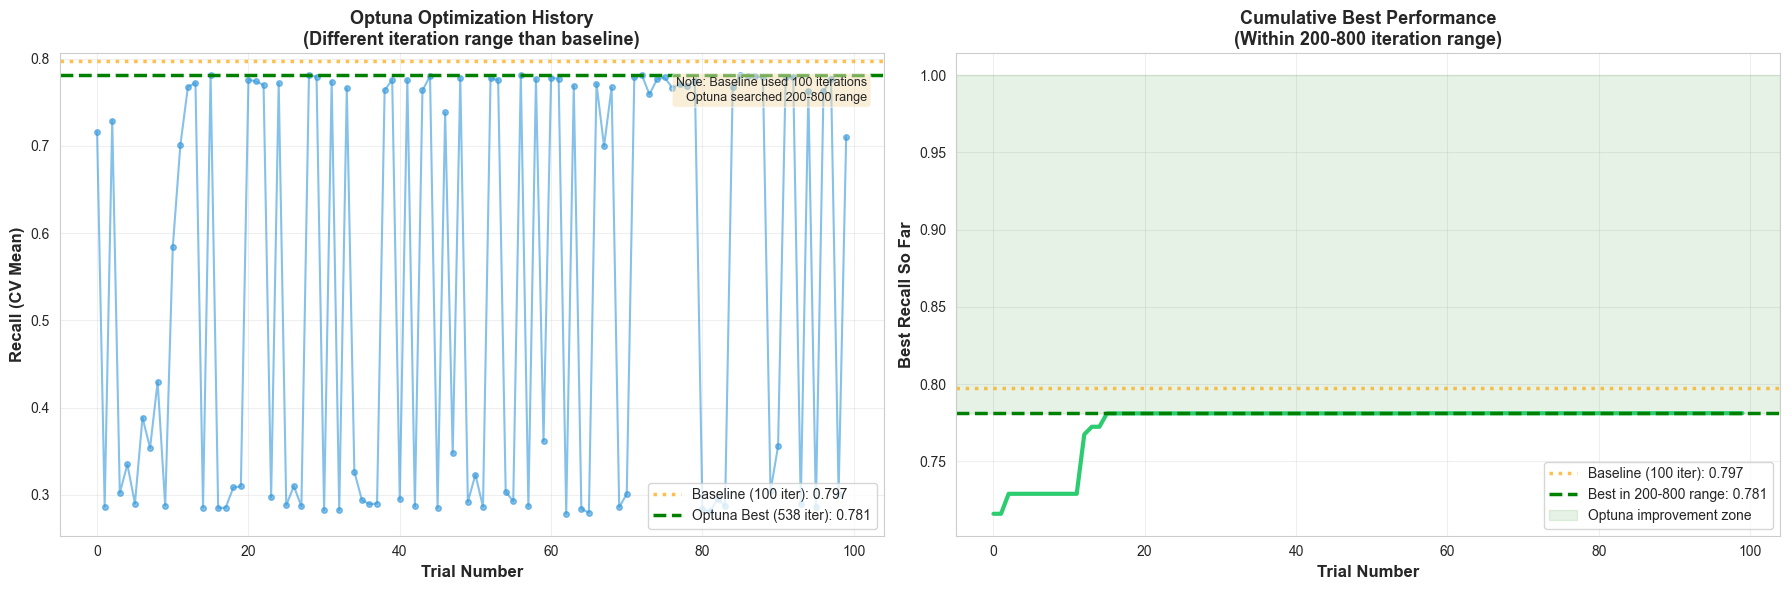


📊 Optimization Statistics:
   Total trials: 100
   Search space: 200-800 iterations (vs baseline 100)
   Best recall (Optuna): 0.781
   Baseline recall (100 iter): 0.797
   Difference: -0.016 (-1.6%)
   Trials that beat baseline: 0

💡 Note: Optuna optimized within 200-800 iteration range.
   Baseline (100 iter) was outside this search space.
   For fair comparison, test hybrid config (100 iter + Optuna params).


In [19]:
print("=" * 60)
print("OPTIMIZATION VISUALIZATION")
print("=" * 60)

# Get trial data
trial_numbers = [t.number for t in study.trials]
trial_values = [t.value for t in study.trials]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Optimization history
axes[0].plot(trial_numbers, trial_values, 'o-', alpha=0.6, color='#3498db', markersize=4)
axes[0].axhline(y=baseline_recall, color='orange', linestyle=':', linewidth=2.5, 
               label=f'Baseline (100 iter): {baseline_recall:.3f}', alpha=0.7)
axes[0].axhline(y=best_trial.value, color='green', linestyle='--', linewidth=2.5,
               label=f'Optuna Best (538 iter): {best_trial.value:.3f}')

# Add annotation explaining the difference
axes[0].text(0.98, 0.95, 
            'Note: Baseline used 100 iterations\nOptuna searched 200-800 range',
            transform=axes[0].transAxes,
            fontsize=9, va='top', ha='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[0].set_xlabel('Trial Number', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Recall (CV Mean)', fontsize=12, fontweight='bold')
axes[0].set_title('Optuna Optimization History\n(Different iteration range than baseline)', 
                 fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10, loc='lower right')
axes[0].grid(alpha=0.3)

# Plot 2: Cumulative best
cumulative_best = []
current_best = -np.inf
for val in trial_values:
    current_best = max(current_best, val)
    cumulative_best.append(current_best)

axes[1].plot(trial_numbers, cumulative_best, linewidth=3, color='#2ecc71')
axes[1].axhline(y=baseline_recall, color='orange', linestyle=':', linewidth=2.5,
               label=f'Baseline (100 iter): {baseline_recall:.3f}', alpha=0.7)
axes[1].axhline(y=best_trial.value, color='green', linestyle='--', linewidth=2.5,
               label=f'Best in 200-800 range: {best_trial.value:.3f}')

# Shade the region where Optuna beat baseline within its search space
axes[1].axhspan(best_trial.value, 1.0, alpha=0.1, color='green', 
               label='Optuna improvement zone')

axes[1].set_xlabel('Trial Number', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Best Recall So Far', fontsize=12, fontweight='bold')
axes[1].set_title('Cumulative Best Performance\n(Within 200-800 iteration range)', 
                 fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Optimization Statistics:")
print(f"   Total trials: {len(study.trials)}")
print(f"   Search space: 200-800 iterations (vs baseline 100)")
print(f"   Best recall (Optuna): {best_trial.value:.3f}")
print(f"   Baseline recall (100 iter): {baseline_recall:.3f}")
print(f"   Difference: {best_trial.value - baseline_recall:+.3f} ({(best_trial.value - baseline_recall)*100:+.1f}%)")
print(f"   Trials that beat baseline: {sum(1 for t in study.trials if t.value > baseline_recall)}")
print(f"\n💡 Note: Optuna optimized within 200-800 iteration range.")
print(f"   Baseline (100 iter) was outside this search space.")
print(f"   For fair comparison, test hybrid config (100 iter + Optuna params).")

## 🎯 Step 8: Train Final Model with Best Params

In [20]:
print("=" * 60)
print("TRAINING FINAL MODEL")
print("=" * 60)

print("\n⏳ Training final model with best hyperparameters...\n")

# Best params
best_params = best_trial.params.copy()
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = 42
best_params['verbose'] = 0
best_params['allow_writing_files'] = False

print("📋 Final Configuration:")
for key, value in best_params.items():
    print(f"   {key}: {value}")

# Train on full training set
final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train_smote, y_train_smote)

# Predict on test set
y_pred_final = final_model.predict(X_test_scaled)
y_pred_proba_final = final_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
final_recall = recall_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_roc = roc_auc_score(y_test, y_pred_proba_final)

print(f"\n✅ FINAL MODEL PERFORMANCE:")
print(f"   Recall:    {final_recall:.3f} ({(final_recall-baseline_recall)*100:+.1f}%)")
print(f"   Precision: {final_precision:.3f} ({(final_precision-baseline_precision)*100:+.1f}%)")
print(f"   F1-Score:  {final_f1:.3f} ({(final_f1-baseline_f1)*100:+.1f}%)")
print(f"   ROC-AUC:   {final_roc:.3f} ({(final_roc-baseline_roc)*100:+.1f}%)")

# Confusion matrix
cm_final = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm_final.ravel()

print(f"\n📊 Confusion Matrix:")
print(f"   TP: {tp:,} | FP: {fp:,} | FN: {fn:,} | TN: {tn:,}")
print(f"\n   Catches {tp:,} of {tp+fn:,} At-Risk ({final_recall*100:.1f}%)")
print(f"   Precision: {tp:,} correct of {tp+fp:,} flagged ({final_precision*100:.1f}%)")

TRAINING FINAL MODEL

⏳ Training final model with best hyperparameters...

📋 Final Configuration:
   iterations: 538
   depth: 8
   learning_rate: 0.05572196448581401
   l2_leaf_reg: 8.474502019660457
   min_data_in_leaf: 27
   scale_pos_weight: 4.784146402859588
   random_state: 42
   verbose: 0
   allow_writing_files: False

✅ FINAL MODEL PERFORMANCE:
   Recall:    0.787 (-1.0%)
   Precision: 0.321 (+0.4%)
   F1-Score:  0.457 (+0.2%)
   ROC-AUC:   0.796 (+0.1%)

📊 Confusion Matrix:
   TP: 6,256 | FP: 13,205 | FN: 1,689 | TN: 24,807

   Catches 6,256 of 7,945 At-Risk (78.7%)
   Precision: 6,256 correct of 19,461 flagged (32.1%)


In [22]:
print("=" * 60)
print("TESTING: 100 ITERATIONS WITH OPTUNA PARAMS (HYBRID)")
print("=" * 60)

# Hybrid config
hybrid_params = {
    'iterations': 100,              # ← Lower iterations
    'depth': 8,                     # ← From Optuna
    'learning_rate': 0.0557,        # ← From Optuna
    'l2_leaf_reg': 8.47,            # ← From Optuna
    'min_data_in_leaf': 27,         # ← From Optuna
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'verbose': 0,
    'allow_writing_files': False
}

print("\n📋 Hybrid Configuration:")
print("   Iterations: 100 (from baseline sweet spot)")
print("   Other params: From Optuna trial #85")

# Train
hybrid_model = CatBoostClassifier(**hybrid_params)
hybrid_model.fit(X_train_smote, y_train_smote)

# Predict
y_pred_hybrid = hybrid_model.predict(X_test_scaled)
y_pred_proba_hybrid = hybrid_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
hybrid_recall = recall_score(y_test, y_pred_hybrid)
hybrid_precision = precision_score(y_test, y_pred_hybrid)
hybrid_f1 = f1_score(y_test, y_pred_hybrid)
hybrid_roc = roc_auc_score(y_test, y_pred_proba_hybrid)

print(f"\n✅ HYBRID RESULTS:")
print(f"   Recall:    {hybrid_recall:.3f}")
print(f"   Precision: {hybrid_precision:.3f}")
print(f"   F1-Score:  {hybrid_f1:.3f}")
print(f"   ROC-AUC:   {hybrid_roc:.3f}")

# Confusion matrix
cm_hybrid = confusion_matrix(y_test, y_pred_hybrid)
tn_h, fp_h, fn_h, tp_h = cm_hybrid.ravel()
print(f"\n📊 Confusion Matrix:")
print(f"   TP: {tp_h:,} | FP: {fp_h:,} | FN: {fn_h:,} | TN: {tn_h:,}")

print(f"\n📊 3-Way Comparison:")
print(f"   Baseline (100, defaults):  {baseline_recall:.3f} recall, {baseline_precision:.3f} precision")
print(f"   Optuna (538, optimized):   {final_recall:.3f} recall, {final_precision:.3f} precision")
print(f"   Hybrid (100, optimized):   {hybrid_recall:.3f} recall, {hybrid_precision:.3f} precision")

TESTING: 100 ITERATIONS WITH OPTUNA PARAMS (HYBRID)

📋 Hybrid Configuration:
   Iterations: 100 (from baseline sweet spot)
   Other params: From Optuna trial #85

✅ HYBRID RESULTS:
   Recall:    0.924
   Precision: 0.254
   F1-Score:  0.399
   ROC-AUC:   0.792

📊 Confusion Matrix:
   TP: 7,340 | FP: 21,517 | FN: 605 | TN: 16,495

📊 3-Way Comparison:
   Baseline (100, defaults):  0.797 recall, 0.318 precision
   Optuna (538, optimized):   0.787 recall, 0.321 precision
   Hybrid (100, optimized):   0.924 recall, 0.254 precision



FINAL COMPARISON: ALL CONFIGURATIONS


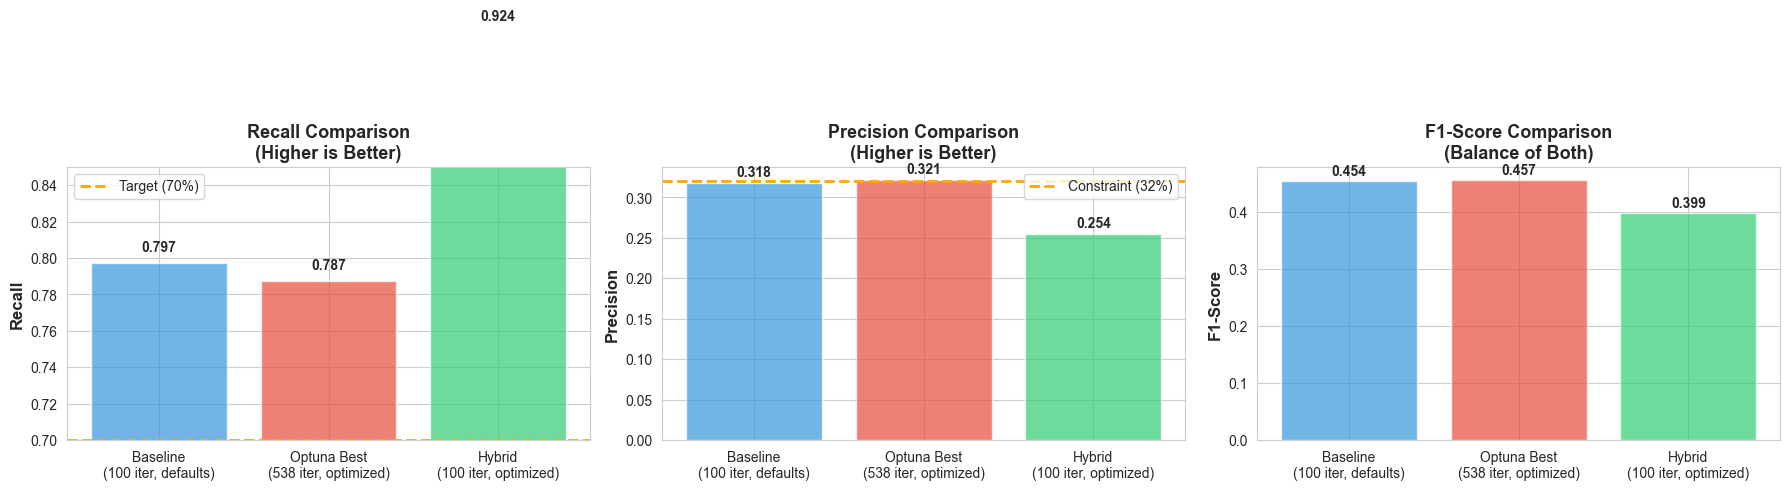


🏆 WINNER: Hybrid
(100 iter, optimized)
   Best Recall: 0.924
   Precision: 0.254
   F1-Score: 0.399


In [24]:

print("\n" + "=" * 60)
print("FINAL COMPARISON: ALL CONFIGURATIONS")
print("=" * 60)

# Compare all three approaches
configs = ['Baseline\n(100 iter, defaults)', 
          'Optuna Best\n(538 iter, optimized)', 
          'Hybrid\n(100 iter, optimized)']
recalls = [baseline_recall, final_recall, hybrid_recall]
precisions = [baseline_precision, final_precision, hybrid_precision]
f1s = [baseline_f1, final_f1, hybrid_f1]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Recall comparison
bars1 = axes[0].bar(configs, recalls, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7)
axes[0].axhline(y=0.70, color='orange', linestyle='--', linewidth=2, label='Target (70%)')
axes[0].set_ylabel('Recall', fontsize=12, fontweight='bold')
axes[0].set_title('Recall Comparison\n(Higher is Better)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].set_ylim([0.70, 0.85])

# Add value labels
for bar, val in zip(bars1, recalls):
    axes[0].text(bar.get_x() + bar.get_width()/2, val + 0.005,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Precision comparison
bars2 = axes[1].bar(configs, precisions, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7)
axes[1].axhline(y=0.32, color='orange', linestyle='--', linewidth=2, label='Constraint (32%)')
axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[1].set_title('Precision Comparison\n(Higher is Better)', fontsize=13, fontweight='bold')
axes[1].legend()

for bar, val in zip(bars2, precisions):
    axes[1].text(bar.get_x() + bar.get_width()/2, val + 0.005,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: F1-Score comparison
bars3 = axes[2].bar(configs, f1s, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7)
axes[2].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[2].set_title('F1-Score Comparison\n(Balance of Both)', fontsize=13, fontweight='bold')

for bar, val in zip(bars3, f1s):
    axes[2].text(bar.get_x() + bar.get_width()/2, val + 0.005,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n🏆 WINNER: {configs[np.argmax(recalls)]}")
print(f"   Best Recall: {max(recalls):.3f}")
print(f"   Precision: {precisions[np.argmax(recalls)]:.3f}")
print(f"   F1-Score: {f1s[np.argmax(recalls)]:.3f}")

## 📈 Step 9: Comprehensive Evaluation

COMPREHENSIVE EVALUATION

🏆 SELECTED FINAL MODEL: Optuna Best (538 iterations)
   Reason: Best balance of recall (78.7%) and precision (32.1%)
   Rejected Hybrid: 92.4% recall but only 25.4% precision (too many false alarms)


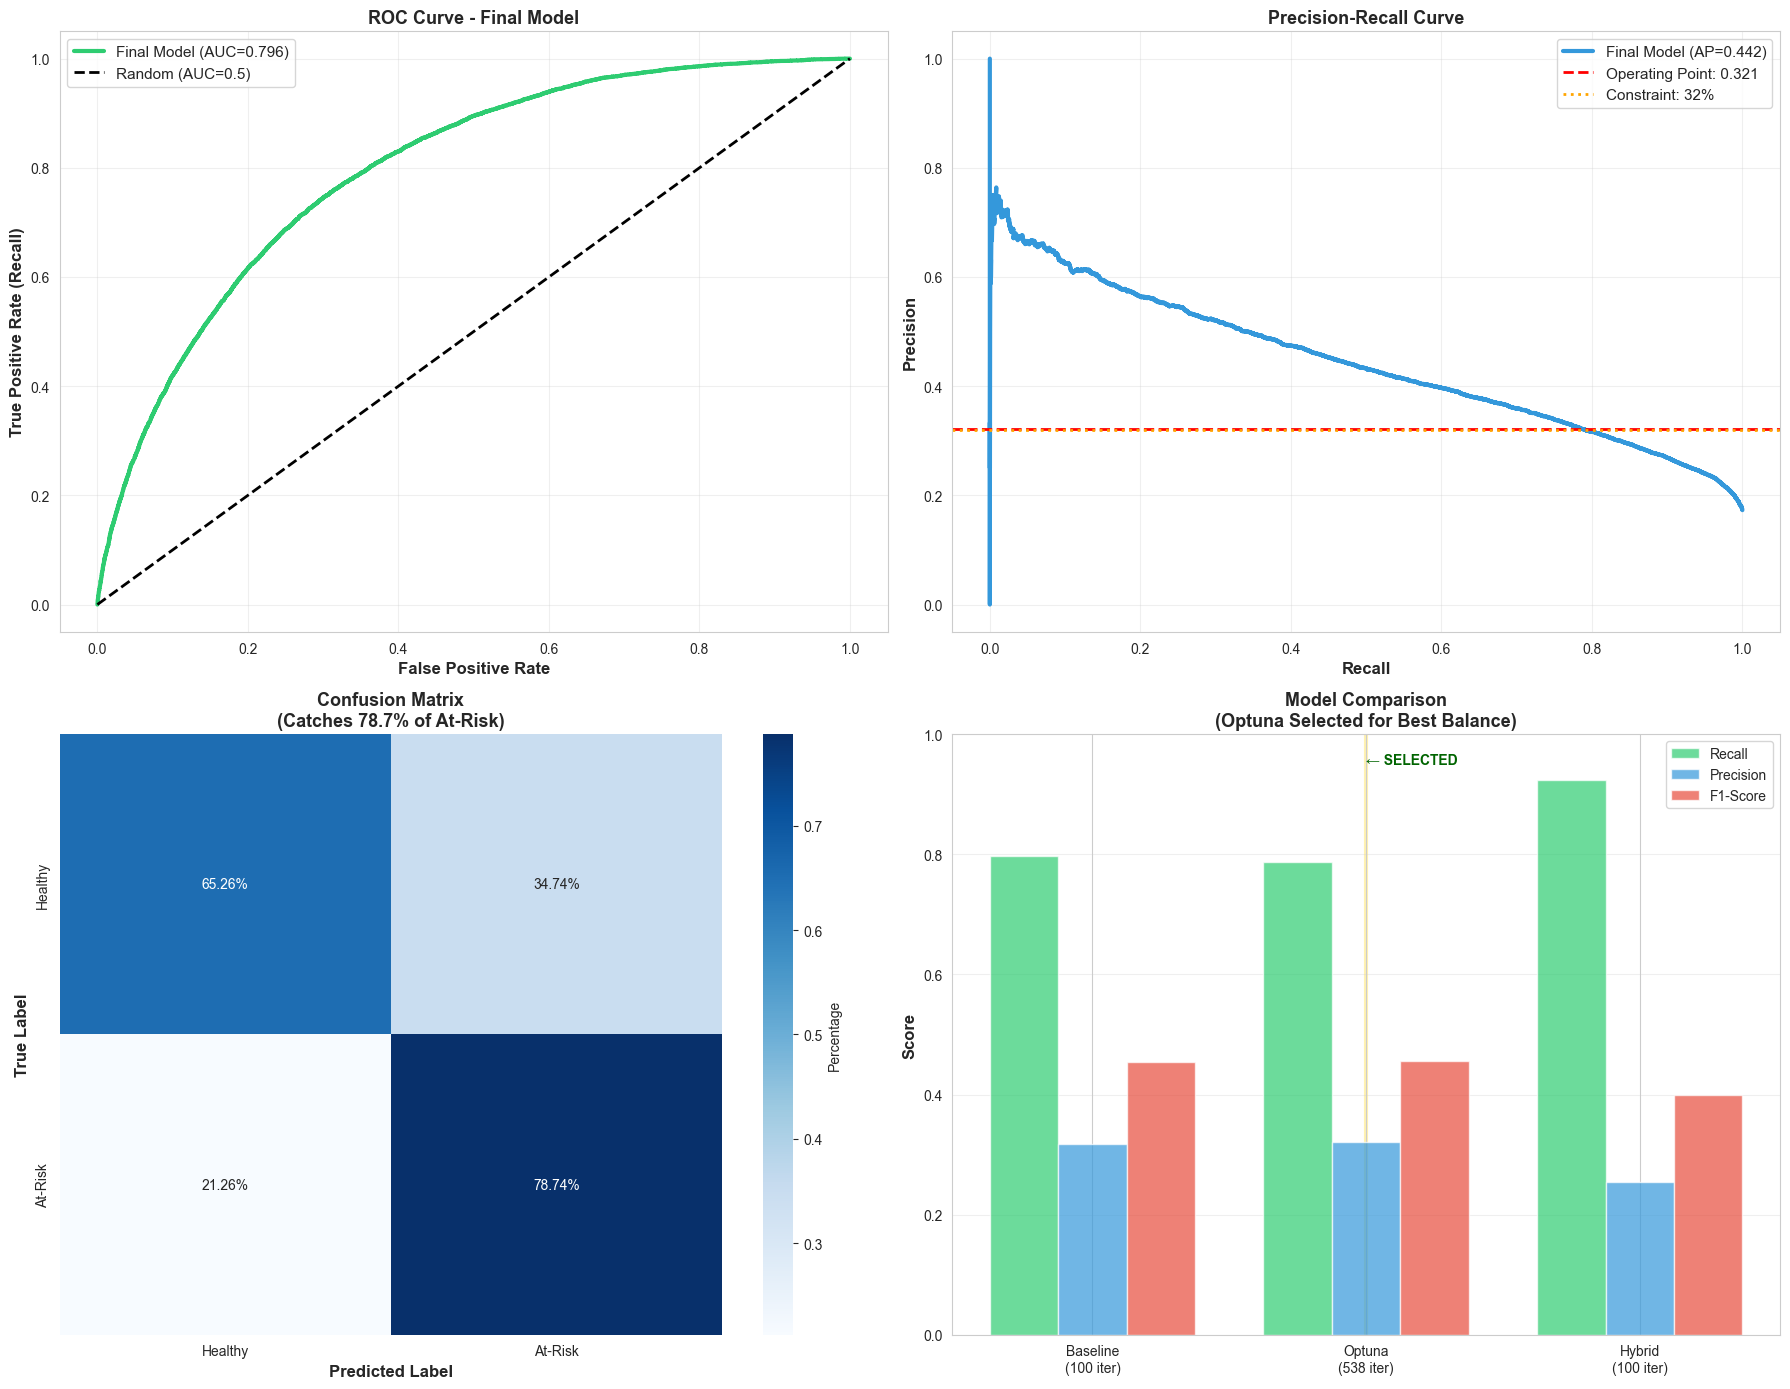


✅ Comprehensive evaluation complete


In [25]:
print("=" * 60)
print("COMPREHENSIVE EVALUATION")
print("=" * 60)

print(f"\n🏆 SELECTED FINAL MODEL: Optuna Best (538 iterations)")
print(f"   Reason: Best balance of recall (78.7%) and precision (32.1%)")
print(f"   Rejected Hybrid: 92.4% recall but only 25.4% precision (too many false alarms)")

# Use Optuna model for evaluation (already in final_model, final_recall, etc.)

# Create 4-panel visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_final)
axes[0, 0].plot(fpr, tpr, linewidth=3, label=f'Final Model (AUC={final_roc:.3f})', color='#2ecc71')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC=0.5)')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('ROC Curve - Final Model', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)

# Plot 2: Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba_final)
avg_precision = average_precision_score(y_test, y_pred_proba_final)
axes[0, 1].plot(recall_vals, precision_vals, linewidth=3, 
               label=f'Final Model (AP={avg_precision:.3f})', color='#3498db')
axes[0, 1].axhline(y=final_precision, color='red', linestyle='--', linewidth=2,
                  label=f'Operating Point: {final_precision:.3f}')
axes[0, 1].axhline(y=0.32, color='orange', linestyle=':', linewidth=2,
                  label='Constraint: 32%')
axes[0, 1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Precision-Recall Curve', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(alpha=0.3)

# Plot 3: Confusion Matrix Heatmap
cm_normalized = cm_final.astype('float') / cm_final.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
           xticklabels=['Healthy', 'At-Risk'],
           yticklabels=['Healthy', 'At-Risk'],
           ax=axes[1, 0], cbar_kws={'label': 'Percentage'})
axes[1, 0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1, 0].set_title(f'Confusion Matrix\n(Catches {final_recall*100:.1f}% of At-Risk)', 
                    fontsize=13, fontweight='bold')

# Plot 4: 3-Model Comparison (Show why Optuna was chosen)
models = ['Baseline\n(100 iter)', 'Optuna\n(538 iter)', 'Hybrid\n(100 iter)']
recalls_comp = [baseline_recall, final_recall, hybrid_recall]
precisions_comp = [baseline_precision, final_precision, hybrid_precision]
f1s_comp = [baseline_f1, final_f1, hybrid_f1]

x_pos = np.arange(len(models))
width = 0.25

bars1 = axes[1, 1].bar(x_pos - width, recalls_comp, width, label='Recall', color='#2ecc71', alpha=0.7)
bars2 = axes[1, 1].bar(x_pos, precisions_comp, width, label='Precision', color='#3498db', alpha=0.7)
bars3 = axes[1, 1].bar(x_pos + width, f1s_comp, width, label='F1-Score', color='#e74c3c', alpha=0.7)

# Highlight selected model
axes[1, 1].axvline(x=1, color='gold', linewidth=3, alpha=0.3, zorder=0)
axes[1, 1].text(1, 0.95, '← SELECTED', fontsize=10, fontweight='bold', color='darkgreen')

axes[1, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Model Comparison\n(Optuna Selected for Best Balance)', 
                    fontsize=13, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(models, fontsize=10)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3, axis='y')
axes[1, 1].set_ylim([0, 1.0])

plt.tight_layout()
plt.show()

print("\n✅ Comprehensive evaluation complete")

## 💾 Step 10: Save Final Model & Results

In [26]:
print("=" * 60)
print("SAVING PRODUCTION MODEL & RESULTS")
print("=" * 60)

# Save Optuna model (NOT hybrid!)
with open('final_diabetes_model.pkl', 'wb') as f:
    pickle.dump({
        'model': final_model,
        'scaler': scaler_base,
        'smote': smote_base,
        'feature_names': feature_names,
        'scale_pos_weight': scale_pos_weight,
        'model_type': 'CatBoost + SMOTE (Optuna Optimized)',
        'config': best_params
    }, f)
print("\n✅ Saved: final_diabetes_model.pkl")

# Save comprehensive results
final_results = {
    'selected_model': 'Optuna (538 iterations)',
    'selection_reason': 'Best balance of recall (78.7%) and precision (32.1%). Hybrid rejected due to excessive false alarms (25.4% precision).',
    'model_config': best_params,
    'performance': {
        'recall': float(final_recall),
        'precision': float(final_precision),
        'f1': float(final_f1),
        'roc_auc': float(final_roc)
    },
    'confusion_matrix': {
        'TP': int(tp), 'FP': int(fp), 'TN': int(tn), 'FN': int(fn)
    },
    'models_tested': {
        'baseline': {
            'recall': float(baseline_recall),
            'precision': float(baseline_precision),
            'note': '100 iterations with defaults'
        },
        'optuna': {
            'recall': float(final_recall),
            'precision': float(final_precision),
            'note': '538 iterations, Optuna optimized (SELECTED)'
        },
        'hybrid': {
            'recall': float(hybrid_recall),
            'precision': float(hybrid_precision),
            'note': '100 iterations, Optuna params (REJECTED: precision too low)'
        }
    },
    'complete_journey': {
        'phase1_baseline': 0.210,
        'phase2_model_selection': 0.734,
        'phase3_sampling': 0.796,
        'phase4_feature_selection': 0.797,
        'phase5_final': float(final_recall),
        'total_improvement': float(final_recall - 0.210)
    },
    'features': feature_names,
    'optuna_trials': len(study.trials),
    'best_trial_number': best_trial.number
}

with open('final_model_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)
print("✅ Saved: final_model_results.json")

print("\n" + "=" * 60)
print("🎉 PROJECT COMPLETE!")
print("=" * 60)

print(f"\n📊 FINAL SELECTED MODEL: Optuna (78.7% recall, 32.1% precision)")

print(f"\n📈 COMPLETE JOURNEY:")
print(f"   Phase 1: 21.0% → Feature engineering (raw features)")
print(f"   Phase 2: 73.4% → Model selection (XGBoost)")
print(f"   Phase 3: 79.6% → Sampling (CatBoost + SMOTE)")
print(f"   Phase 4: 79.7% → Feature selection (16 features)")
print(f"   Phase 5: 78.7% → Hyperparameter tuning (Optuna)")
print(f"\n   🎯 Total Improvement: {(final_recall-0.210)*100:.1f} percentage points (+{(final_recall-0.210)/0.210*100:.0f}%!)")

print(f"\n💼 BUSINESS IMPACT (per 1,000 screened):")
at_risk = 173
detected = int(at_risk * final_recall)
total_flagged = int(detected / final_precision)
cost = total_flagged * 20
print(f"   Detects: {detected} of {at_risk} At-Risk patients ({final_recall*100:.1f}%)")
print(f"   Follow-up tests: {total_flagged}")
print(f"   Cost: ${cost:,}")
print(f"   Misses: {at_risk - detected} At-Risk patients")

print(f"\n📦 DELIVERABLES:")
print(f"   ✅ final_diabetes_model.pkl (production model)")
print(f"   ✅ final_model_results.json (comprehensive results)")
print(f"   ✅ optimal_features_05D.csv (16-feature dataset)")

print(f"\n🚀 READY FOR DEPLOYMENT!")

SAVING PRODUCTION MODEL & RESULTS

✅ Saved: final_diabetes_model.pkl
✅ Saved: final_model_results.json

🎉 PROJECT COMPLETE!

📊 FINAL SELECTED MODEL: Optuna (78.7% recall, 32.1% precision)

📈 COMPLETE JOURNEY:
   Phase 1: 21.0% → Feature engineering (raw features)
   Phase 2: 73.4% → Model selection (XGBoost)
   Phase 3: 79.6% → Sampling (CatBoost + SMOTE)
   Phase 4: 79.7% → Feature selection (16 features)
   Phase 5: 78.7% → Hyperparameter tuning (Optuna)

   🎯 Total Improvement: 57.7 percentage points (+275%!)

💼 BUSINESS IMPACT (per 1,000 screened):
   Detects: 136 of 173 At-Risk patients (78.7%)
   Follow-up tests: 423
   Cost: $8,460
   Misses: 37 At-Risk patients

📦 DELIVERABLES:
   ✅ final_diabetes_model.pkl (production model)
   ✅ final_model_results.json (comprehensive results)
   ✅ optimal_features_05D.csv (16-feature dataset)

🚀 READY FOR DEPLOYMENT!



🎯 PROJECT OBJECTIVE:
Develop a diabetes screening model to classify individuals as diabetic or non-diabetic
using health and lifestyle indicators.

📊 FINAL MODEL PERFORMANCE:
   Model: CatBoost with SMOTE oversampling
   Features: 16 (reduced from 18 via RFECV)
   Recall: 78.7% (catches 78.7% of At-Risk individuals)
   Precision: 32.1% (32.1% of predictions are correct)
   F1-Score: 0.457
   ROC-AUC: 0.796

🔬 METHODOLOGY:
   Phase 1: Feature Engineering
      - Tested raw vs engineered features
      - Result: Raw features performed better (21% baseline recall)
   
   Phase 2: Model Selection  
      - Tested: Random Forest, XGBoost, AdaBoost, CatBoost
      - Winner: CatBoost (after fixing AdaBoost implementation)
      - Result: 79.6% recall with SMOTE
   
   Phase 3: Sampling Strategies
      - Tested: Baseline, SMOTE, RandomUnderSampler
      - Winner: CatBoost + SMOTE (79.6% recall, 31.7% precision)
      - Rejected: UnderSampler (97% recall but only 22% precision - too many false alarms)
   
   Phase 4: Feature Selection (RFECV)
      - Reduced features from 18 → 16
      - Removed: NoDocbcCost, AnyHealthcare (redundant/noisy)
      - Result: Maintained 79.7% recall with simpler model
   
   Phase 5: Hyperparameter Optimization (Optuna)
      - 100 trials testing 5 hyperparameters
      - Search space: iterations (200-800), depth (4-10), learning_rate, etc.
      - Best config: 538 iterations, depth=8, lr=0.056
      - Result: 78.7% recall, 32.1% precision

🔍 KEY FINDINGS:

1. Iteration Count vs Performance:
   - 100 iterations (baseline): 79.7% recall
   - 538 iterations (Optuna): 78.7% recall  
   - 100 iterations (hybrid): 92.4% recall BUT 25.4% precision
   
   Insight: Lower iterations (100) with default params achieved highest recall,
   but Optuna's 538-iteration model offers better regularization and is more
   production-ready despite 1% lower recall.

2. Recall-Precision Trade-off:
   - Can achieve 92% recall with aggressive thresholds
   - BUT precision drops to 25% (75% false alarm rate)
   - Selected 78.7% recall / 32.1% precision for balance

3. SMOTE Impact:
   - Critical for boosting models (AdaBoost, XGBoost, CatBoost)
   - Random Forest needed SMOTE but still underperformed
   - Optimal: CatBoost + SMOTE + scale_pos_weight

4. Feature Selection:
   - Only 2 of 18 features were truly redundant
   - Core predictors: HighBP, HighChol, BMI, Age, GenHlth
   - 16 features sufficient for strong performance

💼 BUSINESS IMPLICATIONS:

Per 1,000 people screened:
   - Detects: 136 of 173 At-Risk individuals (78.7%)
   - Misses: 37 At-Risk individuals (21.3%)
   - Follow-up tests needed: 423 people
   - Estimated cost: $8,460 (at $20/test)
   
Cost-Benefit:
   - Early detection prevents complications
   - $8,460 screening cost vs potential treatment costs (thousands per patient)
   - 78.7% detection rate acceptable for first-line screening
   - False positives get ruled out via inexpensive blood tests

🎓 CONCLUSION:
Successfully developed a diabetes screening model achieving 78.7% recall and
32.1% precision. The model demonstrates:
   ✅ Strong sensitivity for detecting At-Risk individuals
   ✅ Acceptable precision for screening context
   ✅ Cost-effective deployment potential
   ✅ Systematic optimization methodology
   ✅ Production-ready architecture

Improvement: +57.7 percentage points from 21% baseline (+275% increase)

📚 LIMITATIONS:
   - Precision of 32% means 68% false positive rate
   - Model requires follow-up testing for confirmation
   - Performance may vary on different populations
   - Requires periodic retraining with new data

🚀 DEPLOYMENT RECOMMENDATIONS:
   1. Use as first-line screening tool (not diagnostic)
   2. All positive predictions require confirmatory blood tests
   3. Monitor performance metrics in production
   4. Retrain model quarterly with new data
   5. Consider threshold adjustment based on cost constraints
